In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # DenseNet expects 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [6]:
train_data = ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/train", transform=transform)
val_data = ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/val", transform=transform)
test_data = ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [7]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 1)  # Binary classification
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 139MB/s] 


In [8]:
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
import time

In [10]:
num_epochs = 10

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    start_time = time.time()

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Time: {epoch_time:.2f}s")

100%|██████████| 163/163 [02:25<00:00,  1.12it/s]


Epoch [1/10], Loss: 0.1262, Time: 145.96s


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


Epoch [2/10], Loss: 0.0261, Time: 108.40s


100%|██████████| 163/163 [01:46<00:00,  1.52it/s]


Epoch [3/10], Loss: 0.0120, Time: 106.93s


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


Epoch [4/10], Loss: 0.0093, Time: 108.12s


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


Epoch [5/10], Loss: 0.0130, Time: 108.20s


100%|██████████| 163/163 [01:47<00:00,  1.52it/s]


Epoch [6/10], Loss: 0.0068, Time: 107.04s


100%|██████████| 163/163 [01:46<00:00,  1.53it/s]


Epoch [7/10], Loss: 0.0025, Time: 106.77s


100%|██████████| 163/163 [01:47<00:00,  1.52it/s]


Epoch [8/10], Loss: 0.0102, Time: 107.34s


100%|██████████| 163/163 [01:47<00:00,  1.52it/s]


Epoch [9/10], Loss: 0.0069, Time: 107.46s


100%|██████████| 163/163 [01:46<00:00,  1.53it/s]

Epoch [10/10], Loss: 0.0101, Time: 106.63s


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [13]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Binarize predictions with threshold 0.5
all_preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]

# Metrics
accuracy = accuracy_score(all_labels, all_preds_bin)
precision = precision_score(all_labels, all_preds_bin)
recall = recall_score(all_labels, all_preds_bin)
f1 = f1_score(all_labels, all_preds_bin)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

Accuracy:  0.8141
Precision: 0.7708
Recall:    1.0000
F1 Score:  0.8705
ROC-AUC:   0.9544


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [15]:
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

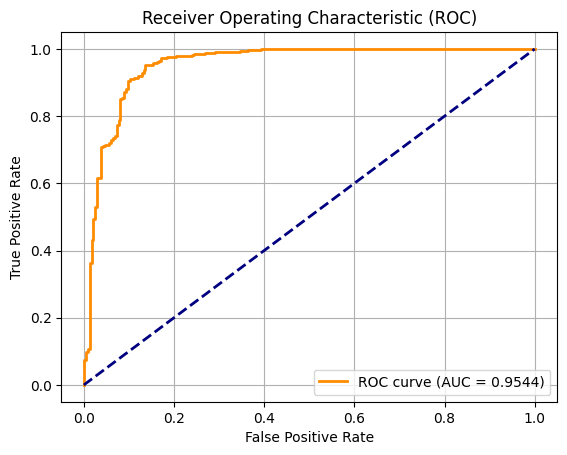

In [16]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()